In [170]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

In [179]:
import pandas as pd

# Cargar el conjunto de datos desde un archivo CSV
data_path = r"C:\Proyectos programación\Modelos\consumo_casa.csv"
data = pd.read_csv(data_path)

# Eliminar la primera columna (asumiendo que se llama 'Unnamed: 0')
data.drop(columns=['Unnamed: 0'], inplace=True)

# Convertir la columna 'Fecha' a tipo datetime si no lo está
data['Fecha'] = pd.to_datetime(data['Fecha'])



# Dividir la columna 'Fecha' en mes, día, hora y minuto
data['Mes'] = data['Fecha'].dt.month
data['Dia'] = data['Fecha'].dt.day
data['Hora'] = data['Fecha'].dt.hour
data['Minuto'] = data['Fecha'].dt.minute

# Calcular la columna 'otros'
data['otros'] = data['Medidor [W]'] - data[['Refrigerator', 'Clothes washer', 'Clothes Iron', 'Computer', 'Oven', 'Play', 'TV', 'Sound system']].sum(axis=1)

print(data)


                     Fecha  Medidor [W]  Refrigerator  Clothes washer  \
0      2017-06-07 00:00:00      228.887         134.6             1.0   
1      2017-06-07 00:01:00      231.814         134.6             0.2   
2      2017-06-07 00:02:00      230.971         131.3             0.3   
3      2017-06-07 00:03:00      231.878         131.3             0.0   
4      2017-06-07 00:04:00      189.225           0.0             0.1   
...                    ...          ...           ...             ...   
194118 2017-10-22 23:55:00       88.272           0.1             1.4   
194119 2017-10-22 23:56:00       86.386           1.0             1.3   
194120 2017-10-22 23:57:00       85.766           0.0             1.8   
194121 2017-10-22 23:58:00       87.665           0.4             0.0   
194122 2017-10-22 23:59:00       86.988           0.3             0.7   

        Clothes Iron  Computer  Oven  Play   TV  Sound system  Mes  Dia  Hora  \
0                0.0       0.3   0.1   0.0

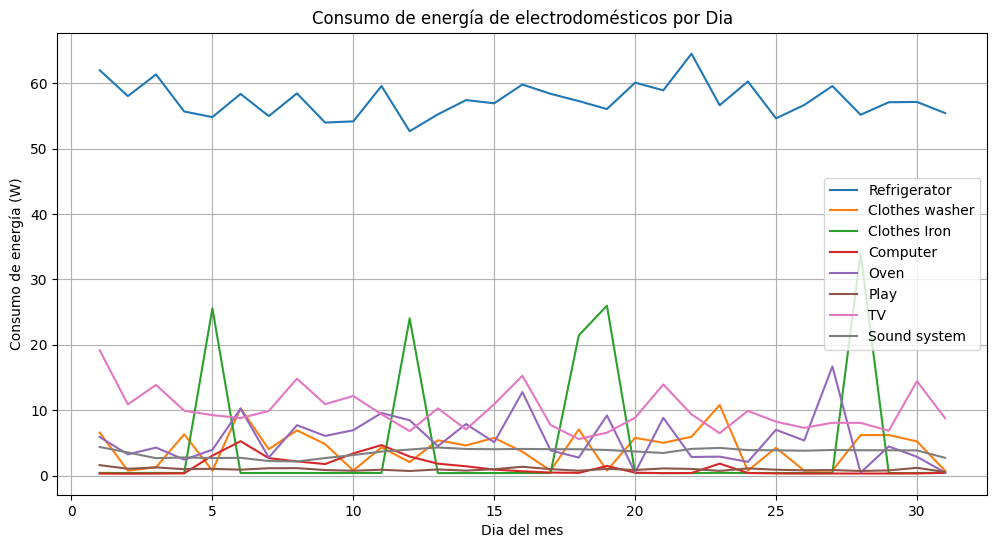

In [188]:
import matplotlib.pyplot as plt

# Lista de electrodomésticos
electrodomesticos = ['Refrigerator', 'Clothes washer', 'Clothes Iron', 'Computer', 'Oven', 'Play', 'TV', 'Sound system']

# Configuración de la figura y los ejes
plt.figure(figsize=(12, 6))
plt.title('Consumo de energía de electrodomésticos por Dia')
plt.xlabel('Dia del mes')
plt.ylabel('Consumo de energía (W)')

# Iterar sobre cada electrodoméstico y graficar su consumo por hora
for electrodomestico in electrodomesticos:
    consumo_por_hora = data.groupby('Dia')[electrodomestico].mean()
    plt.plot(consumo_por_hora.index, consumo_por_hora, label=electrodomestico)

# Agregar leyenda y mostrar la gráfica
plt.legend()
plt.grid(True)
plt.show()


In [176]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Aplicar funciones seno y coseno a las variables de predicción (y)
variables_prediccion = ['Refrigerator', 'Clothes washer', 'Clothes Iron', 'Computer', 'Oven', 'Play', 'TV', 'Sound system','Medidor [W]']
for variable in variables_prediccion:
    data[f'{variable}_seno'] = np.sin(2 * np.pi * data[variable] / 24)
    data[f'{variable}_coseno'] = np.cos(2 * np.pi * data[variable] / 24)

# Dividir los datos en características (X) y etiquetas (y)
X = data[['Mes', 'Dia', 'Hora', 'Minuto', 'Medidor [W]_seno','Medidor [W]_coseno']]
y = data[[f'{variable}_seno' for variable in variables_prediccion] + [f'{variable}_coseno' for variable in variables_prediccion]]

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construir el modelo de regresión lineal
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Evaluar el modelo
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print("R2 score en entrenamiento:", train_score)
print("R2 score en prueba:", test_score)


R2 score en entrenamiento: 0.9206019187565384
R2 score en prueba: 0.4314719806317096


In [173]:
from sklearn.metrics import mean_squared_error

# Predecir los valores en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred)

print("Error cuadrático medio:", mse)


Error cuadrático medio: 0.09961934273558173


In [174]:
from sklearn.metrics import mean_squared_error

# Predecir los valores en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el error cuadrático medio por cada columna
mse_por_columna = {}
for i, columna in enumerate(y.columns):
    mse_por_columna[columna] = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])

# Imprimir el MSE por cada columna
for columna, mse_valor in mse_por_columna.items():
    print(f"MSE para {columna}: {mse_valor}")


MSE para Refrigerator_seno: 0.2001997748180972
MSE para Clothes washer_seno: 0.03728439097097165
MSE para Clothes Iron_seno: 0.014290904964032652
MSE para Computer_seno: 0.030523709620016545
MSE para Oven_seno: 0.016551932870516484
MSE para Play_seno: 0.08420776850720767
MSE para TV_seno: 0.12085024441090508
MSE para Sound system_seno: 0.15880267548097474
MSE para Medidor [W]_seno: 1.4727837283008882e-29
MSE para Refrigerator_coseno: 0.6151113013334706
MSE para Clothes washer_coseno: 0.07484265464898912
MSE para Clothes Iron_coseno: 0.008103878105664262
MSE para Computer_coseno: 0.0398458546887346
MSE para Oven_coseno: 0.00571056415614348
MSE para Play_coseno: 0.03198533226096372
MSE para TV_coseno: 0.2222239296054376
MSE para Sound system_coseno: 0.1326132527983479
MSE para Medidor [W]_coseno: 6.1546398266299955e-30


In [175]:
# Elegir la variable para la cual mostrar los valores (por ejemplo, 'Refrigerator')
variable_elegida = 'Refrigerator'

# Obtener los primeros 5 valores reales y predichos para la variable elegida
primeros_5_valores = pd.DataFrame({
    'Valor Real': y_test[f'{variable_elegida}_seno'].iloc[:10].values,
    'Valor Predicho': y_pred[:10, y.columns.get_loc(f'{variable_elegida}_seno')]
})

# Mostrar los primeros 5 valores reales y predichos
print(f"Valores reales y predichos para la variable '{variable_elegida}' para los primeros 5 datos:")
print(primeros_5_valores)


Valores reales y predichos para la variable 'Refrigerator' para los primeros 5 datos:
   Valor Real  Valor Predicho
0    0.544639        0.095658
1    0.309017        0.141018
2    0.284015        0.134530
3    0.000000        0.113420
4    0.284015        0.122518
5    0.983255        0.111450
6    0.078459        0.128538
7    0.104528        0.143267
8    0.207912        0.124065
9    0.000000        0.107611
